# Using Large Language Models for Inferential Regression Modelling in Social Sciences


In this tutorial, we look at the following regression model:

`performace ~ 1 + specificity`

That is, we regress student performances on specificity scores.

First, we're going to simulate some data for performance and specificity. With this simulated dataset, we can investigate how measurement error affects regression results.

Second, we're going to learn how to correct for measurement error with Gabrielle Martins van Jaarsveld's SoDa fellowship dataset.

## Warning!

Before you proceed, please note that the Google Colab Environment makes it difficult/impossible to install R packages directly from GitHub. This is inconvenient for us because all we are going to work with the `dsl` package which is great for correcting measurement error in regression models.

For this consideration, we suggest that you run the code in this notebook on your **local computer** instead.

In [ ]:
# Install required packages
if(!require(tidyverse)) install.packages("tidyverse")
if(!require(gridExtra)) install.packages("gridExtra")
if(!require(devtools)) install.packages("devtools")
library(devtools)
install_github("naoki-egami/dsl", dependencies = FALSE)

In [ ]:
# Load required packages
library(tidyverse)
library(gridExtra)
library(dsl)

## Influence of measurement error on regression modelling

Let's simulate some data.

In [ ]:
set.seed(42)  # Set seed for reproducibility

# Simulate true X (specificity) and Y (performance)
n <- 100
x_true <- sample(0:2, n, replace = TRUE)
beta <- 0.5  # True regression coefficient
intercept <- 0
y <- intercept + beta * x_true + rnorm(n, mean = 0, sd = 0.1)  # Adding noise to y

Introduce systematic and random error into the predictor x.

In [ ]:
# Introduce measurement errors
systematic_error <- 1  # Systematic shift in x
random_error <- rnorm(n, mean = 0, sd = 1)  # Random error

x_systematic <- x_true + systematic_error  # X with systematic measurement error
x_random <- round(x_true + random_error)  # X with random measurement error
x_random[x_random < 0] <- 0  # Ensure values are within range
x_random[x_random > 2] <- 2

#### Influence of systematic error in regression modelling

In [ ]:
# Function to fit and plot regression
plot_regression <- function(x, y, label, x_ticks) {
  model <- lm(y ~ x)  # Fit linear model

  # Scatter plot with regression line
  library(ggplot2)
  plot <- ggplot(data.frame(x, y), aes(x = x, y = y)) +
    geom_point(size = 2) +
    geom_smooth(method = "lm", se = TRUE, color = "blue") +
    labs(title = paste0(label, "\nEstimated β = ", round(coef(model)[2], 2)),
         x = "X: Specificity",
         y = "Y: Performance") +
    scale_x_continuous(breaks = x_ticks)

  return(plot)
}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


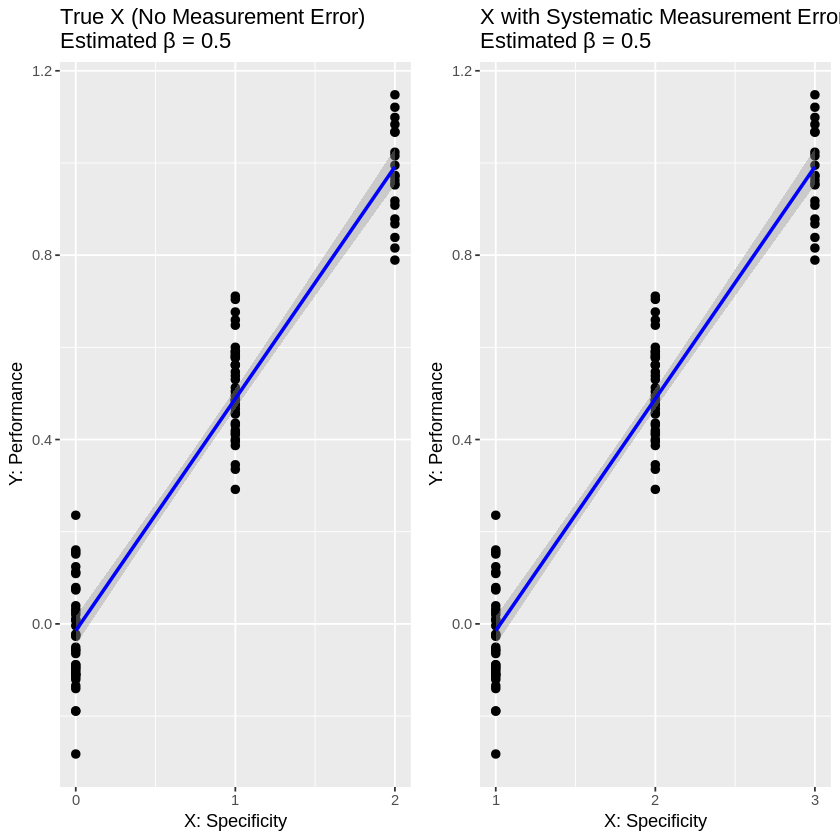

In [ ]:
# Create plots

p1 <- plot_regression(x_true, y, "True X (No Measurement Error)", c(0,1,2,3))
p2 <- plot_regression(x_systematic, y, "X with Systematic Measurement Error", c(0,1,2,3))

grid.arrange(p1, p2, ncol = 2)

#### Influence of random error in regression modelling

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


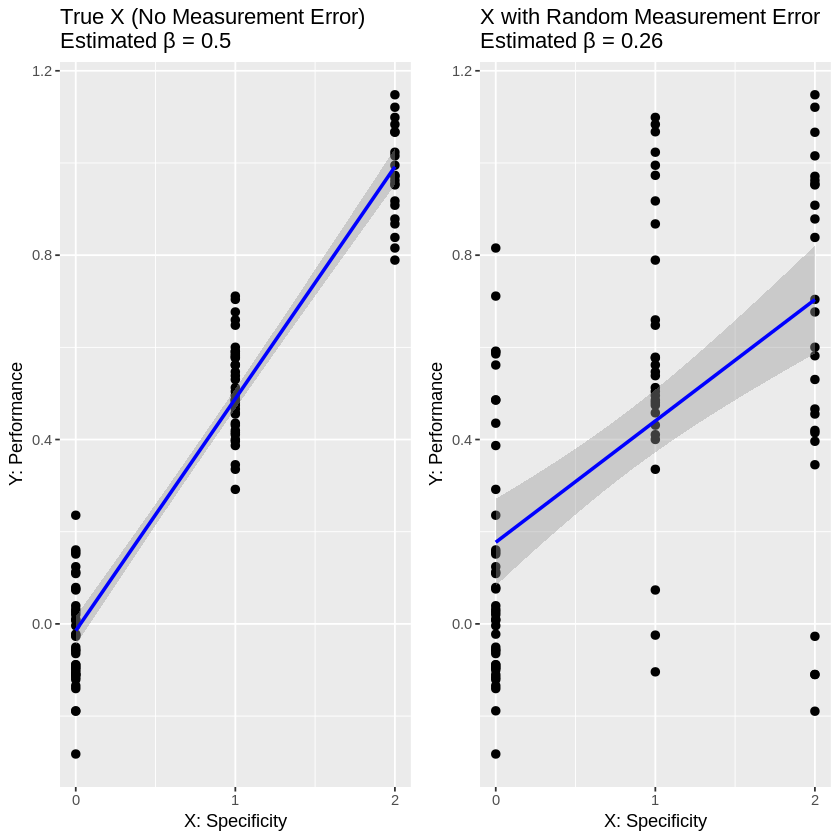

In [ ]:
# Plot X with random measurement error
p3 <- plot_regression(x_random, y, "X with Random Measurement Error", c(0,1,2))

grid.arrange(p1, p3, ncol = 2)

## Correcting measurement error in regression with the DSL package

Now that we have seen how measurement errror can affect statistical modelling, let's try to correct for it!

We will use the same toy dataset as in the previous tutorial, which comes from Gabrielle Martins van Jaarsveld's SoDa fellowship project on annotating markers of self-regulated learning from student conversation data. Feel free to use your own data.

For R users, the `DSL` package comes in handy for this purpose. Note that `DSL` can handle measurement error in both the predictors as well as the outcome variable in a regression model.

Unfortunately, there is no existing **Python** package that can handle measurement error in predictors of regression model. To keep both the R and the Python notebooks consistent with each other, we are going to assume measurement error only in the outcome variable for the regression analysis we are going to conduct next.

For alternatives, see below or check out https://github.com/sodascience/social_science_inferences_with_llms

### Software Packages
| Name | Method | Language | Estimators | Predicted Variables |
|----|----|----|----|----|
| [PostPI](https://github.com/leekgroup/postpi) | Post-Prediction Inference | R | Means, quantitles and GLMs | Outcome |
| [PPI, PPI++, Cross-PPI, PPBoot](https://github.com/aangelopoulos/ppi_py) | Prediction-powered inference and its extensions | Python | Any arbitrary estimator | Outcome |
| [PSPA](https://github.com/qlu-lab/pspa) | PoSt-Prediction Adaptive inference | R | Means, quantiles, linear regression, logistic regression | Predictor and outcome |
| [ipd](https://github.com/ipd-tools/ipd) | Implemented PostPI, PPI, PPI++ and PSPA | R | Means, quantiles, linear regression, logistic regression | Outcome |
| [PSPS](https://github.com/qlu-lab/psps) | PoSt-Prediction Summary-statistics-based (PSPS) inference | R and Python | M-estimators | Outcome |
| [DSL](https://naokiegami.com/dsl/) | Design-based Supervised Learning | R | Moment-based estimators | Predictor and outcome |


### Data loading

In [ ]:
# Google Sheets export link
sheet_url <- "https://docs.google.com/spreadsheets/d/1yLKp2HYW2gPlJv1kyqjjr1qLtOA-O5pPGttAMX5wvbY/export?format=csv"

# Read CSV into DataFrame
df <- read_csv(sheet_url)

### Build a gold dataset and regression

First, let's build a subset of Gabrielle's dataset that contains only gold labels (i.e., error-free measurements).

In [ ]:
df_gold <- df |>
  filter(!is.na(score_specificity_human), !is.na(performance)) |>
  slice(rep(1:n(), each = 5))  # Expanding the dataset 5 times

gold_fit <- lm(performance ~ score_specificity_human, data = df_gold)
summary(gold_fit)
confint(gold_fit)


Call:
lm(formula = performance ~ score_specificity_human, data = df_gold)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3280 -0.4280  0.1720  0.6348  1.8092 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)               6.4908     0.1561  41.571   <2e-16 ***
score_specificity_human   0.3372     0.1401   2.406   0.0174 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.116 on 143 degrees of freedom
Multiple R-squared:  0.03892,	Adjusted R-squared:  0.0322 
F-statistic: 5.791 on 1 and 143 DF,  p-value: 0.01739


,2.5 %,97.5 %
(Intercept),6.18212962,6.7993921
score_specificity_human,0.06022324,0.6142333


We know now that for these observations, the gold regression coefficient is 0.337 with a confidence interval of [0.060, 0.614] and statistical significance at 0.05 alpha level.

To proceed with the assumption that we only correct for measurement error in the outcome variable of the regression model (instead of the predictor variable), let's also assume that:

1. The specificity measurements (i.e., the predictor) are completely observed and error free;
2. In contrast, the performance measurements (i.e., the outcome variable) are only partially observed (i.e., we only have partial labels) and for the unobserved y values, we have their corresponding predictions (y_hat), which can come from LLMs and likely suffer from measurement error. To simplify our analysis, we will manually make these predictions instead of using LLMs.

### Create performance predictions and data partitions

Let's create a predicted performance variable (`performance_pred`) by introducing measurement error into the original `performance` variable.

In [ ]:
set.seed(42)
bias <- 1

df_gold <- df_gold |>
  mutate(performance_pred = performance - bias + rnorm(n(), mean = 0, sd = 0.5))

We shuffle the dataset and split it into two partitions: `df_observed` where we have both error-free measurements and predictions, and `df_unobserved` where we have only predictions.

In [ ]:
set.seed(1)
df_gold_shuffled <- df_gold |>
  sample_frac(1, replace = FALSE)  # Shuffle rows

p_unobserved_y <- 0.5
n_unobserved_y <- floor(p_unobserved_y * nrow(df_gold))

df_observed <- df_gold_shuffled |> slice(1:(n() - n_unobserved_y))
df_unobserved <- df_gold_shuffled |> slice((n() - n_unobserved_y + 1):n())

### Regression model with observed partition

What happens if we run a regression model on the observed partition? That is, we ignore all the prediction-based data.

In [ ]:
observed_fit <- lm(performance ~ score_specificity_human, data = df_observed)
summary(observed_fit)
confint(observed_fit)


Call:
lm(formula = performance ~ score_specificity_human, data = df_observed)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2393 -0.8393  0.2607  0.6676  1.9676 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)               6.3324     0.2234  28.344   <2e-16 ***
score_specificity_human   0.4069     0.2121   1.918   0.0591 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.094 on 71 degrees of freedom
Multiple R-squared:  0.04928,	Adjusted R-squared:  0.03589 
F-statistic: 3.681 on 1 and 71 DF,  p-value: 0.05907


,2.5 %,97.5 %
(Intercept),5.88693727,6.7778775
score_specificity_human,-0.01600683,0.8297928


You can see that the regression coefficient is estimated to be 0.407, much bigger than the gold value 0.337 and is no longer statistically significant at 0.05 alpha level. The confidence interval also now contains zero.

### Corrected regression model on all data using `dsl`

To use the `dsl` package to correct our regression estimates, we need to prepare a new dataset where on the outcome variable we have missing gold labels.

In [ ]:
df_dsl <- df_unobserved |>
  mutate(performance = NA) |>
  bind_rows(df_observed)

In [ ]:
out_lm <- dsl(model = "lm",
              formula = performance ~ score_specificity_human,
              predicted_var = "performance",
              prediction = "performance_pred",
              data = df_dsl)
summary(out_lm)

We can see that the corrected regression estimate (0.324) is closer than the uncorrected one (0.407) to the true value (0.337).

We can also see that the confidence interval no longer contains zero, which also indicates likely statistical significance at 0.05 alpha level.

### Exercise: Try your own data!

In [ ]:
# Let's write some code!